This file covers the process of adding the scaled density, magnetic field average, longitude difference and latitude difference to the existing data that we have for Artemis and Pioneer.

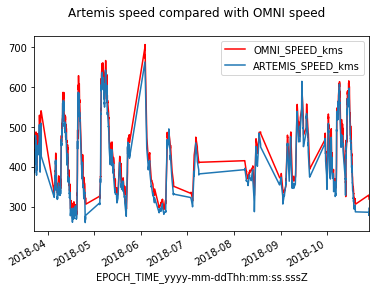

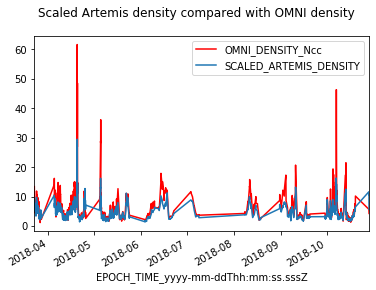

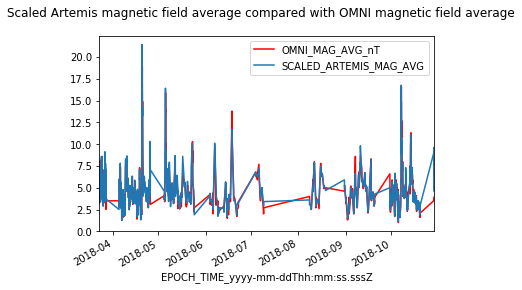

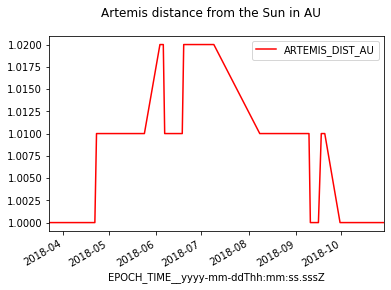

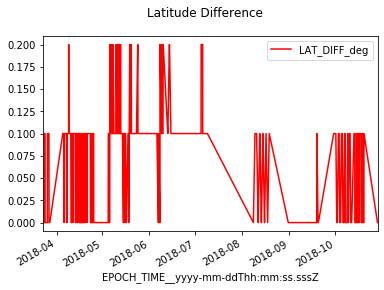

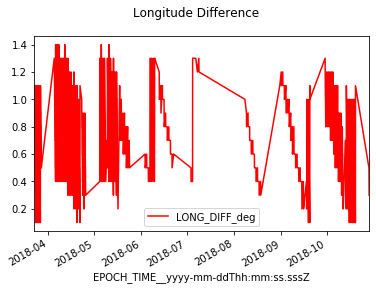

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

posFrame = pd.read_csv('csv files/POS4Artemis1Year.csv')
windFrame = pd.read_csv('csv files/SW4Artemis1Year.csv')
windFrame = windFrame.loc[:, ~windFrame.columns.str.contains('^Unnamed')]
posFrame = posFrame.loc[:, ~posFrame.columns.str.contains('^Unnamed')]
windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
windFrame['date'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'])
posFrame['date'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
mergedFrame = pd.merge(windFrame, posFrame, on='date')
mergedFrame = mergedFrame.drop(['date', 'EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], axis=1)
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_MAG_AVG_nt != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_DENSITY_Ncc != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_SPEED_kms != -1.0E+31]

mergedFrame = mergedFrame[mergedFrame['GSE_X_RE'] >= -35]
mergedFrame = mergedFrame[mergedFrame['SSE_X_RM'] >= 0]
mergedFrame = mergedFrame[mergedFrame['ARTEMIS_DIST_AU'] >= 1]
mergedFrame = mergedFrame.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis1Year.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['OMNI_MAG_AVG_nT'] != -1.0E+31]
df2 = df2[df2['OMNI_SPEED_kms'] != -1.0E+31]
df2 = df2[df2['OMNI_DENSITY_Ncc'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

mergedFrame = mergedFrame.drop(['GSE_X_RE', 'GSE_Y_RE', 'GSE_Z_RE', 'SSE_X_RM', 'SSE_Y_RM', 'SSE_Z_RM'], axis=1)
mergedFrame['new_time'] = mergedFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] - pd.Timedelta(hours = 1)
mergedFrame['Time_offset_hours'] = 1

mF = pd.merge(df2, mergedFrame, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

mF['LAT_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LAT_deg - row.ARTEMIS_LAT_DEG), axis = 1)
mF['LONG_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LONG_deg - row.ARTEMIS_LONG_DEG), axis = 1) 
mF['SCALED_ARTEMIS_DENSITY'] = mF.apply(lambda row: row.ARTEMIS_DENSITY_Ncc * row.ARTEMIS_DIST_AU * row.ARTEMIS_DIST_AU, axis = 1)
mF['SCALED_ARTEMIS_MAG_AVG'] = mF.apply(lambda row: row.ARTEMIS_MAG_AVG_nt * row.ARTEMIS_DIST_AU, axis = 1)

fig1 = plt.figure(1)
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_SPEED_kms', color='red', ax=ax)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_SPEED_kms', ax=ax)
#ax.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig2 = plt.figure(2)
fig2.suptitle("Scaled Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_DENSITY_Ncc', color='red', ax=ay)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_ARTEMIS_DENSITY', ax=ay)
#ay.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig3 = plt.figure(3)
fig3.suptitle("Scaled Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_MAG_AVG_nT', color='red', ax=az)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_ARTEMIS_MAG_AVG', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig4 = plt.figure(4)
fig4.suptitle("Artemis distance from the Sun in AU")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_DIST_AU', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig4 = plt.figure(5)
fig4.suptitle("Latitude Difference")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='LAT_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig4 = plt.figure(6)
fig4.suptitle("Longitude Difference")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='LONG_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

plt.show()

mF.describe()

#mF.to_csv('Artemis1YearRedux.csv')

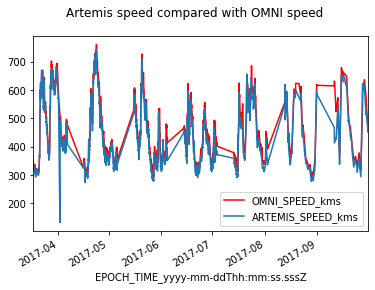

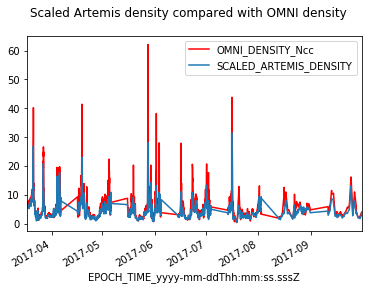

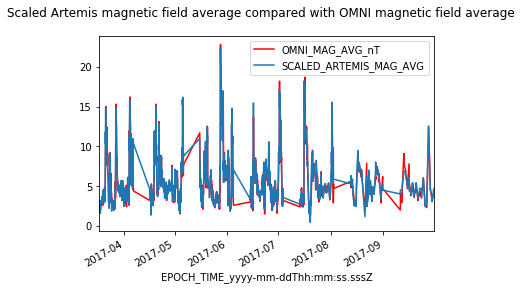

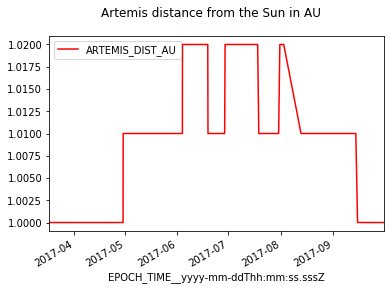

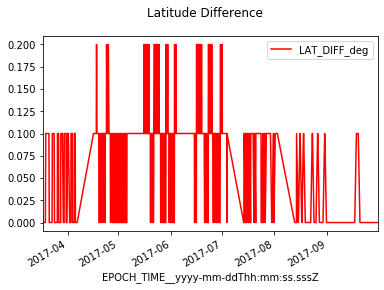

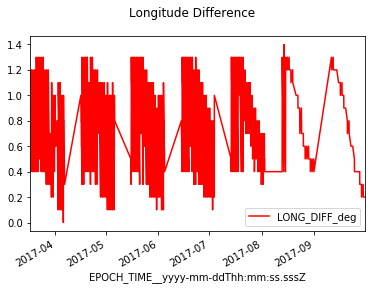

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

posFrame = pd.read_csv('csv files/POS4Artemis1Year2.csv')
windFrame = pd.read_csv('csv files/SW4Artemis1Year2.csv')
windFrame = windFrame.loc[:, ~windFrame.columns.str.contains('^Unnamed')]
posFrame = posFrame.loc[:, ~posFrame.columns.str.contains('^Unnamed')]
windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
windFrame['date'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'])
posFrame['date'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
mergedFrame = pd.merge(windFrame, posFrame, on='date')
mergedFrame = mergedFrame.drop(['date', 'EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], axis=1)
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_MAG_AVG_nt != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_DENSITY_Ncc != -1.0E+31]
mergedFrame = mergedFrame[mergedFrame.ARTEMIS_SPEED_kms != -1.0E+31]

mergedFrame = mergedFrame[mergedFrame['GSE_X_RE'] >= -35]
mergedFrame = mergedFrame[mergedFrame['SSE_X_RM'] >= 0]
mergedFrame = mergedFrame[mergedFrame['ARTEMIS_DIST_AU'] >= 1]
mergedFrame = mergedFrame.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis1Year2.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['OMNI_MAG_AVG_nT'] != -1.0E+31]
df2 = df2[df2['OMNI_SPEED_kms'] != -1.0E+31]
df2 = df2[df2['OMNI_DENSITY_Ncc'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

mergedFrame = mergedFrame.drop(['GSE_X_RE', 'GSE_Y_RE', 'GSE_Z_RE', 'SSE_X_RM', 'SSE_Y_RM', 'SSE_Z_RM'], axis=1)
mergedFrame['new_time'] = mergedFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] - pd.Timedelta(hours = 1)
mergedFrame['Time_offset_hours'] = 1

mF = pd.merge(df2, mergedFrame, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

mF['LAT_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LAT_deg - row.ARTEMIS_LAT_DEG), axis = 1)
mF['LONG_DIFF_deg'] = mF.apply(lambda row: abs(row.OMNI_LONG_deg - row.ARTEMIS_LONG_DEG), axis = 1) 
mF['SCALED_ARTEMIS_DENSITY'] = mF.apply(lambda row: row.ARTEMIS_DENSITY_Ncc * row.ARTEMIS_DIST_AU * row.ARTEMIS_DIST_AU, axis = 1)
mF['SCALED_ARTEMIS_MAG_AVG'] = mF.apply(lambda row: row.ARTEMIS_MAG_AVG_nt * row.ARTEMIS_DIST_AU, axis = 1)

fig1 = plt.figure(1)
fig1.suptitle("Artemis speed compared with OMNI speed")
ax = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_SPEED_kms', color='red', ax=ax)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_SPEED_kms', ax=ax)
#ax.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig2 = plt.figure(2)
fig2.suptitle("Scaled Artemis density compared with OMNI density")
ay = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_DENSITY_Ncc', color='red', ax=ay)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_ARTEMIS_DENSITY', ax=ay)
#ay.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig3 = plt.figure(3)
fig3.suptitle("Scaled Artemis magnetic field average compared with OMNI magnetic field average")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_MAG_AVG_nT', color='red', ax=az)
mF.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_ARTEMIS_MAG_AVG', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig4 = plt.figure(4)
fig4.suptitle("Artemis distance from the Sun in AU")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='ARTEMIS_DIST_AU', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig5 = plt.figure(5)
fig5.suptitle("Latitude Difference")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='LAT_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig6 = plt.figure(6)
fig6.suptitle("Longitude Difference")
az = plt.gca()
mF.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='LONG_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

plt.show()

mF.describe()

#mF.to_csv('Artemis1Year2Redux.csv')

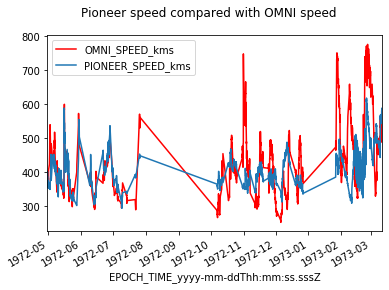

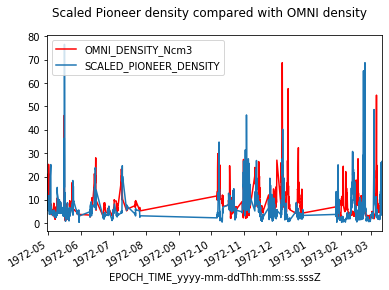

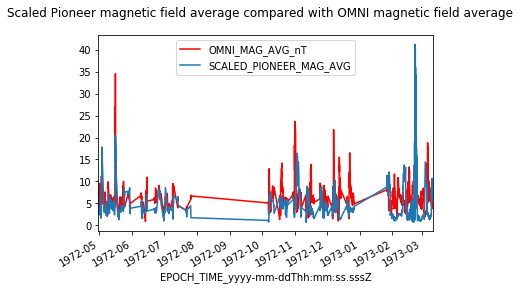

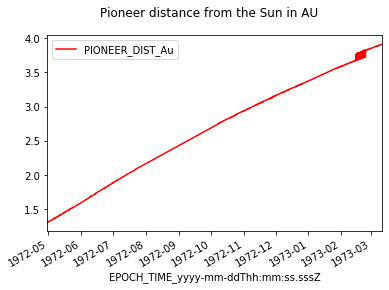

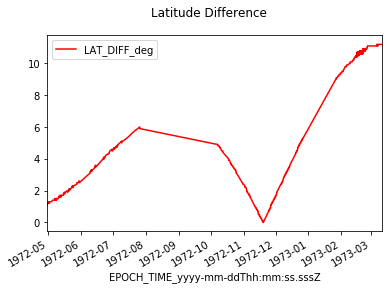

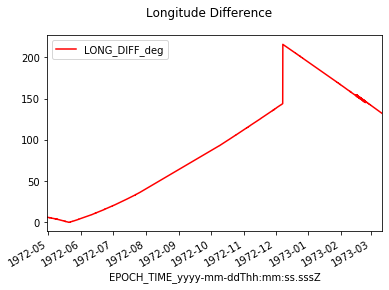

In [5]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

mF0 = pd.read_csv('Pioneer2.csv')

mF0['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(mF0['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])

mF0['LAT_DIFF_deg'] = mF0.apply(lambda row: abs(row.OMNI_LAT_deg - row.PIONEER_LAT_deg), axis = 1)
mF0['LONG_DIFF_deg'] = mF0.apply(lambda row: abs(row.OMNI_LONG_deg - row.PIONEER_LONG_deg), axis = 1) 
mF0['SCALED_PIONEER_DENSITY'] = mF0.apply(lambda row: row.PIONEER_DENSITY_Ncm3 * row.PIONEER_DIST_Au * row.PIONEER_DIST_Au, axis = 1)
mF0['SCALED_PIONEER_MAG_AVG'] = mF0.apply(lambda row: row.PIONEER_MAG_AVG_nT * row.PIONEER_DIST_Au, axis = 1)

fig1 = plt.figure(1)
fig1.suptitle("Pioneer speed compared with OMNI speed")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_SPEED_kms', color='red', ax=ax)
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='PIONEER_SPEED_kms', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig2 = plt.figure(2)
fig2.suptitle("Scaled Pioneer density compared with OMNI density")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_DENSITY_Ncm3', color='red', ax=ax)
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_PIONEER_DENSITY', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig3 = plt.figure(3)
fig3.suptitle("Scaled Pioneer magnetic field average compared with OMNI magnetic field average")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_MAG_AVG_nT', color='red', ax=ax)
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_PIONEER_MAG_AVG', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig4 = plt.figure(4)
fig4.suptitle("Pioneer distance from the Sun in AU")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='PIONEER_DIST_Au', color='red', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig5 = plt.figure(5)
fig5.suptitle("Latitude Difference")
az = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='LAT_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig6 = plt.figure(6)
fig6.suptitle("Longitude Difference")
az = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='LONG_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

plt.show()

mF0.describe()

#mF0.to_csv('Pioneer2Redux.csv')


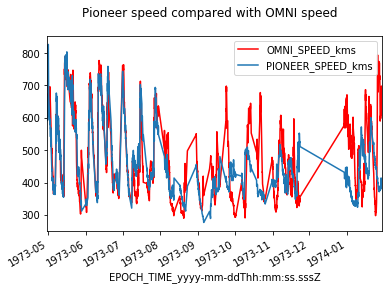

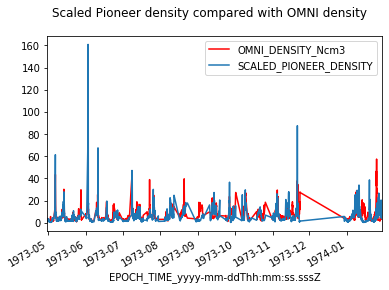

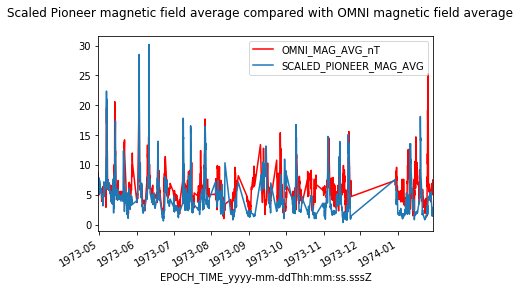

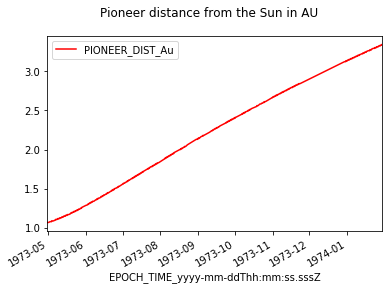

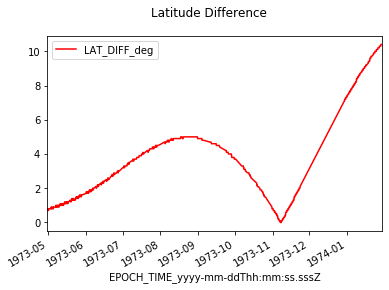

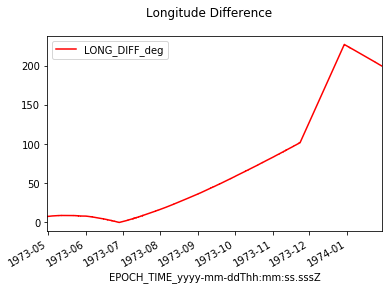

In [6]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

mF0 = pd.read_csv('Pioneer3.csv')

mF0['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(mF0['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])

mF0['LAT_DIFF_deg'] = mF0.apply(lambda row: abs(row.OMNI_LAT_deg - row.PIONEER_LAT_deg), axis = 1)
mF0['LONG_DIFF_deg'] = mF0.apply(lambda row: abs(row.OMNI_LONG_deg - row.PIONEER_LONG_deg), axis = 1) 
mF0['SCALED_PIONEER_DENSITY'] = mF0.apply(lambda row: row.PIONEER_DENSITY_Ncm3 * row.PIONEER_DIST_Au * row.PIONEER_DIST_Au, axis = 1)
mF0['SCALED_PIONEER_MAG_AVG'] = mF0.apply(lambda row: row.PIONEER_MAG_AVG_nT * row.PIONEER_DIST_Au, axis = 1)

fig1 = plt.figure(1)
fig1.suptitle("Pioneer speed compared with OMNI speed")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_SPEED_kms', color='red', ax=ax)
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='PIONEER_SPEED_kms', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig2 = plt.figure(2)
fig2.suptitle("Scaled Pioneer density compared with OMNI density")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_DENSITY_Ncm3', color='red', ax=ax)
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_PIONEER_DENSITY', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig3 = plt.figure(3)
fig3.suptitle("Scaled Pioneer magnetic field average compared with OMNI magnetic field average")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='OMNI_MAG_AVG_nT', color='red', ax=ax)
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='SCALED_PIONEER_MAG_AVG', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig4 = plt.figure(4)
fig4.suptitle("Pioneer distance from the Sun in AU")
ax = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='PIONEER_DIST_Au', color='red', ax=ax)
#ax.set_xlim([datetime.date(1972, 11, 1), datetime.date(1972, 12, 1)])

fig5 = plt.figure(5)
fig5.suptitle("Latitude Difference")
az = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='LAT_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

fig6 = plt.figure(6)
fig6.suptitle("Longitude Difference")
az = plt.gca()
mF0.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='LONG_DIFF_deg', color='red', ax=az)
#az.set_xlim([datetime.date(2018, 3, 15), datetime.date(2018, 11, 1)])

plt.show()

mF0.describe()

#mF0.to_csv('Pioneer3Redux.csv')